In [29]:
"""
Support script for countersunk fastener blog post
Eric Peters
2022-05-03
"""

# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as cf

%matplotlib inline
#%matplotlib notebook


In [17]:
"""
define data
Source: MIL-HDBK-5J / MMPDS-01
  Protruding head: Table 8.1.4.1(a)
  CSK head: Table 8.1.4.2(c) and 8.1.4.2(a)
  Clad 7075-T6: Table 3.7.6.0(c1)

All data for DIA .250 fasteners
"""

# thickness, in
t = np.array([.080, .090, .100, .125, .160, .190, .250])

t_arr = np.array([0.05, 0.063, 0.071, .080, .090, .100, .125, .160, .190, .250])
d_arr = np.array([0.164, 0.190, 0.250])
Pult_csk_arr = np.empty((len(t_arr),3))
Pult_prot_arr = np.empty((len(t_arr),3))

# nominal shank diameter, in
D = 0.250

# countersink head height, in
t_csk = 0.060
t_csk_arr = np.array([0.034, 0.046, 0.060])

# Fastener ultimate shear strength @ shank, lbf
Psu = 4660
Psu_arr = np.array([2007, 2694, 4660])

# Joint ultimate strength CSR925 protruding shear head, lbf
Pult_prot = np.array([2415, 2688, 2960, 3641, 4595, 4660, 4660])

# Joint ultimate strength, CSR924 100* flush shear head, lbf
# dia .164
Pult_csk_arr[:,0] = [941, 1207, 1385, 1557, 1775, 1876, 1950, 2007, 2007, 2007]
# dia .190
Pult_csk_arr[:,1] = [np.nan, 1383, 1588, 1779, 2050, 2263, 2542, 2660, 2694, 2694]
# dia .250
Pult_csk = np.array([2281, 2594, 2919, 3765, 4387, 4525, 4660])
Pult_csk_arr[:,2] = [np.nan, np.nan, np.nan, 2281, 2594, 2919, 3765, 4387, 4525, 4660]

# Ultimate bearing strength, Clad 7075-T6, e/D = 2.0, A-basis, psi
Fbru_2A = 140000
# Ultimate bearing strength, Clad 7075-T6, e/D = 2.0, B-basis, psi
Fbru_2B = 154000

In [44]:
# Maths

# thickness at which bearing strength equals fastener shear strength, in
teq_A = Psu/(Fbru_2A*D)
teq_A_arr = Pult_csk_arr[-1,:]/(Fbru_2A*d_arr)
teq_B = Psu/(Fbru_2B*D)

tbru_A = np.array([0,teq_A, 1.5*max(t)])
tbru_B = np.array([0,teq_B, 1.5*max(t)])
Pbru_2A = np.array([0, Psu, Psu])
Pbru_2B = np.array([0, Psu, Psu])

# calculate bearing/shear ult envelope for each diameter
tenv_arr = np.empty((5,3))
Penv_arr = np.empty_like(tenv_arr)
for i in np.arange(len(teq_A_arr)):
  tenv_arr[:,i] = np.append(np.linspace(0, teq_A_arr[i],4),0.3)
  Penv_arr[:,i] = np.append(tenv_arr[:-1,i]*Fbru_2A*d_arr[i],Psu_arr[i])

# curve fit the csk data using scipy.optimize.cf
# define a curve function
def x3(x, *params):
  a, b, c, d = params
  return a*x**3 + b*x**2 + c*x + d

popt, pcov = cf(x3, t, Pult_csk, p0=[1,1,1,1])

# curve fit the csk data using numpy.polyfit
p3opt = np.polyfit(t, Pult_csk,3) 
p6opt = np.polyfit(t, Pult_csk,6)
x3fit = np.poly1d(p3opt)
x6fit = np.poly1d(p6opt)
tfit = np.arange(min(t),max(t),step=0.005)


In [45]:
Penv_arr

array([[   0.        ,    0.        ,    0.        ],
       [ 669.        ,  898.        , 1553.33333333],
       [1338.        , 1796.        , 3106.66666667],
       [2007.        , 2694.        , 4660.        ],
       [2007.        , 2694.        , 4660.        ]])

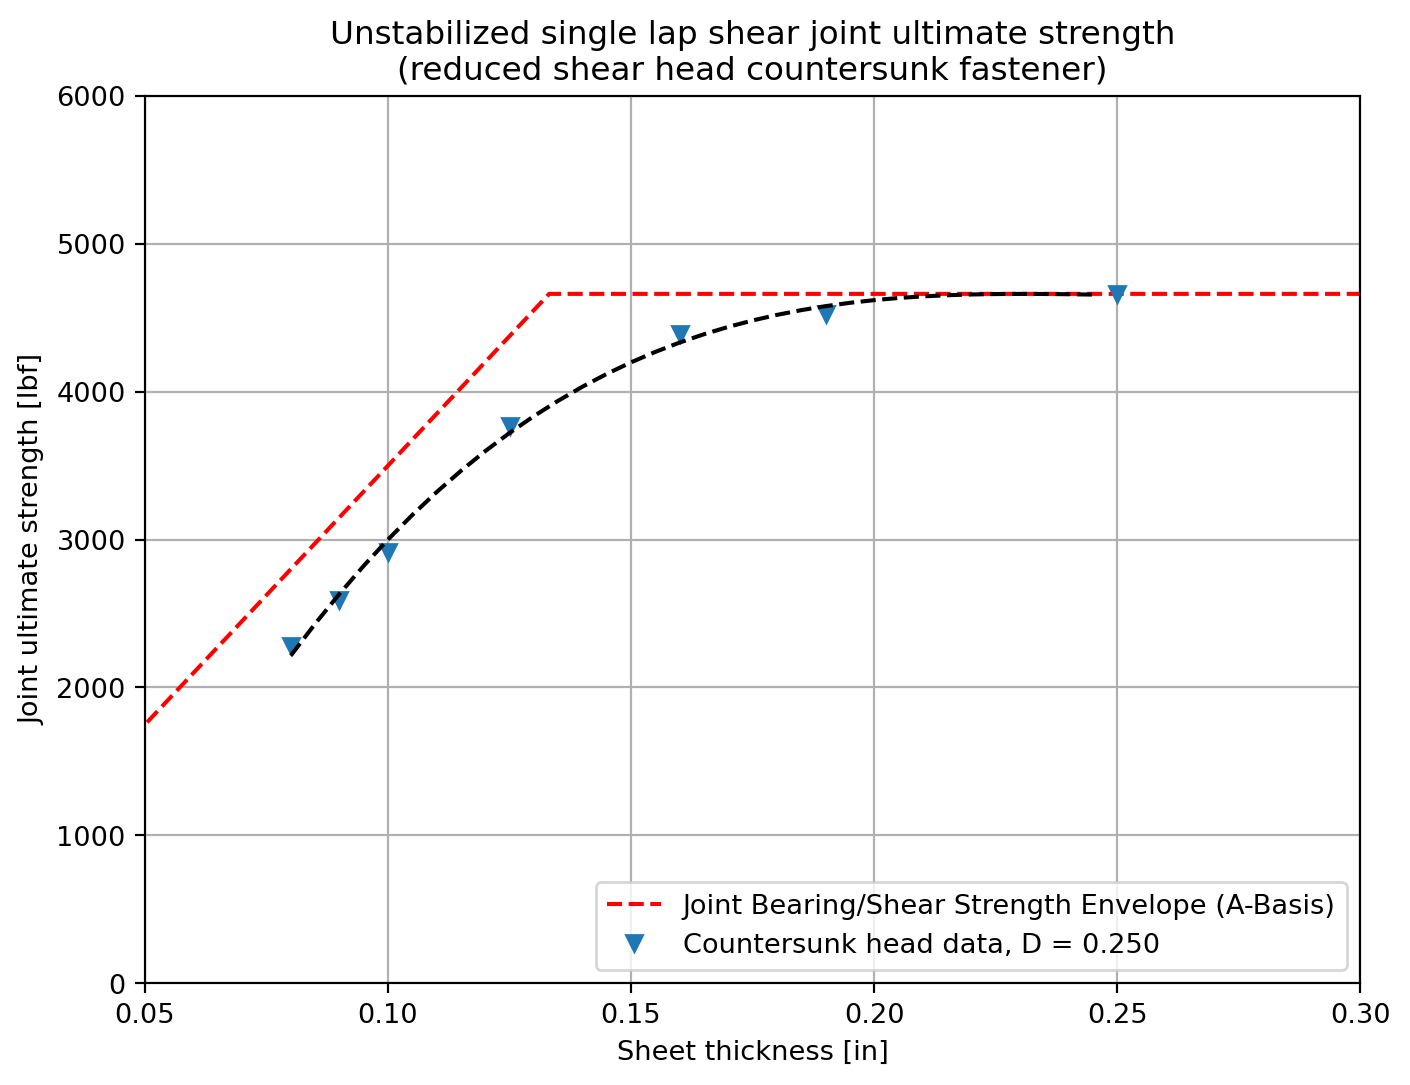

In [19]:
# Plots!

plt.figure(num=1,dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint ultimate strength\n(reduced shear head countersunk fastener)')
plt.xlabel('Sheet thickness [in]')
plt.ylabel('Joint ultimate strength [lbf]')
plt.xlim((0.050, 0.3))
plt.ylim((0,6000))
plt.plot(tbru_A,Pbru_2A,'--r', label='Joint Bearing/Shear Strength Envelope (A-Basis)')
#plt.plot(tbru_B,Pbru_2B,'--b', label='Joint Bearing/Shear Strength Envelope (B-Basis)')
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
plt.plot(t,Pult_csk,'v', label='Countersunk head data, D = 0.250')
#plt.plot(t,Pult_csk/0.85,'v', label='Countersunk head (TYP estimate)')
plt.plot(tfit,x3fit(tfit),'--k')
plt.legend(loc=4)
plt.grid(visible=True, which='both', axis='both')

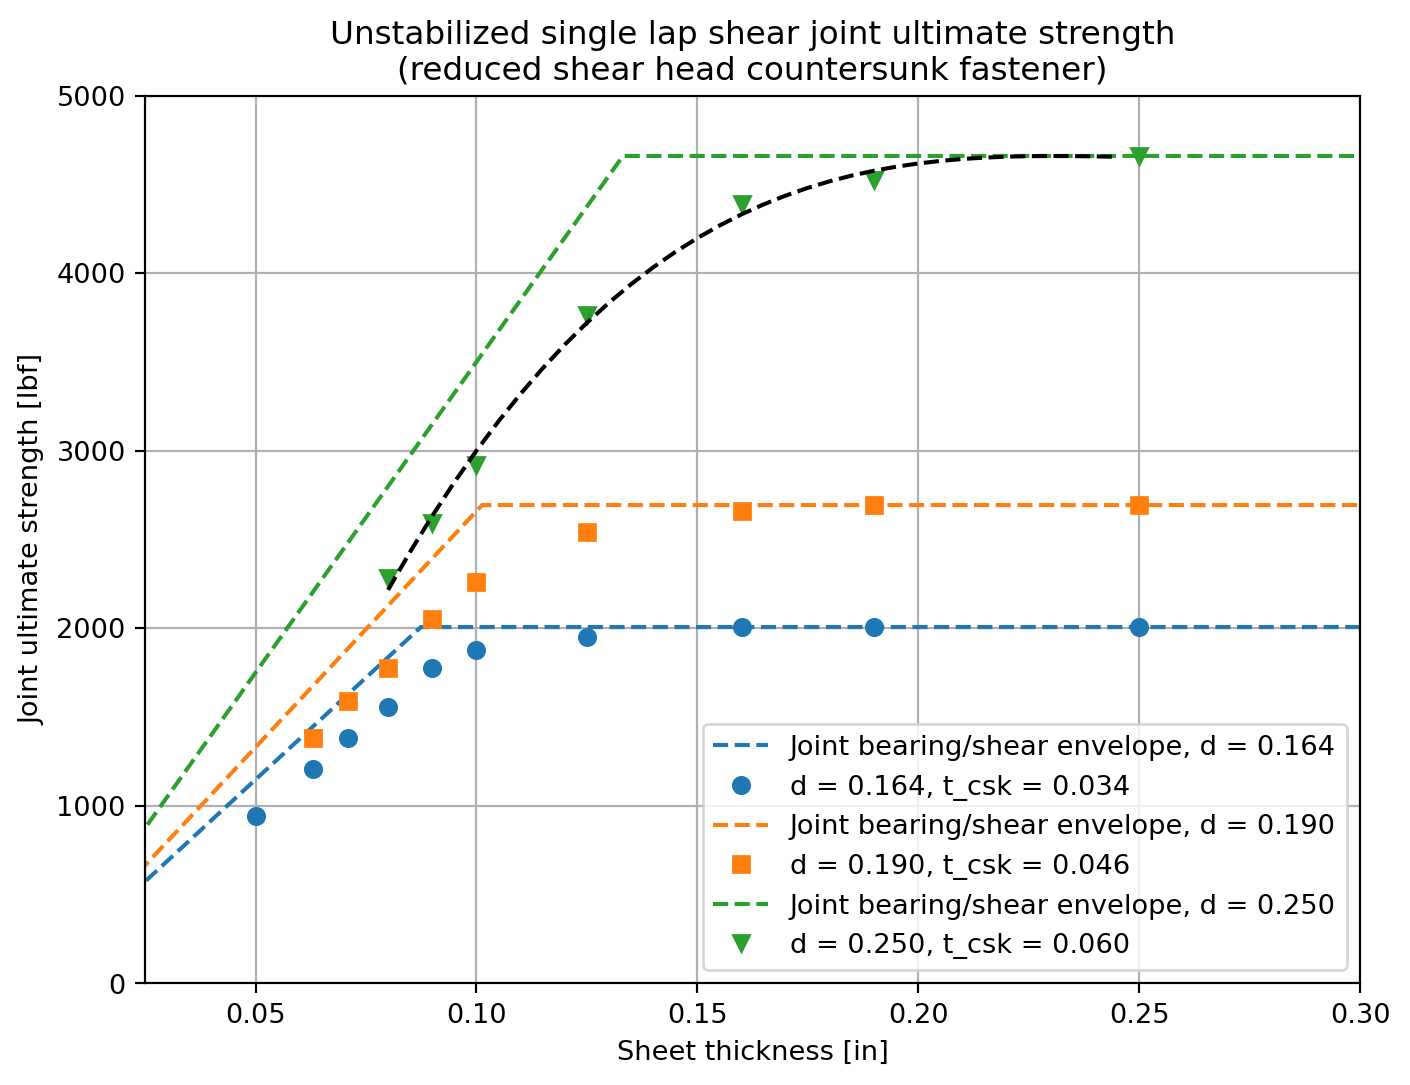

In [50]:
# Plots!
markers = ['o', 's', 'v']

plt.figure(num=5,dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint ultimate strength\n(reduced shear head countersunk fastener)')
plt.xlabel('Sheet thickness [in]')
plt.ylabel('Joint ultimate strength [lbf]')
plt.xlim((0.025, 0.3))
plt.ylim((0,5000))
#plt.plot(tbru_A,Pbru_2A,'--r', label='Joint Bearing/Shear Strength Envelope (A-Basis)')
for i, m in enumerate(markers):
    plt.plot(tenv_arr[:,i],Penv_arr[:,i], linestyle='--', color='C{:d}'.format(i), label='Joint bearing/shear envelope, d = {:.3f}'.format(d_arr[i]))
    plt.plot(t_arr,Pult_csk_arr[:,i],marker=m, linestyle="None", label='d = {:.3f}, t_csk = {:.3f}'.format(d_arr[i],t_csk_arr[i]))
plt.plot(tfit,x3fit(tfit),'--k')
plt.legend(loc=4)
plt.grid(visible=True, which='both', axis='both')

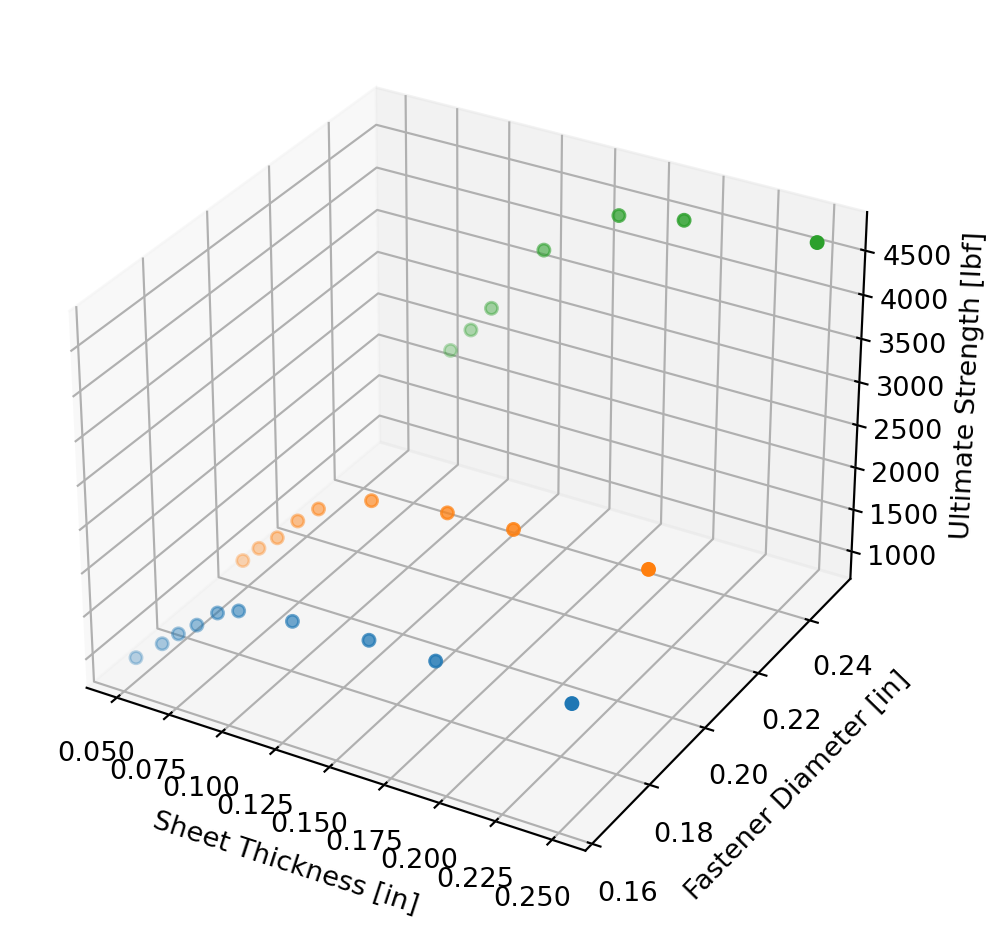

In [33]:
fig3d = plt.figure(dpi=196, figsize=(8,6))
ax = fig3d.add_subplot(projection='3d')
for i in np.arange(0,len(d_arr)):
    ax.scatter(t_arr,d_arr[i],Pult_csk_arr[:,i], color='C{:d}'.format(i))
ax.set_xlabel('Sheet Thickness [in]')
ax.set_ylabel('Fastener Diameter [in]')
ax.set_zlabel('Ultimate Strength [lbf]')
plt.show()

In [80]:
# calculate countersink knockdown two ways
# 1. normalize data by nominal sheet bearing thickness only
# 2. normalize data by joint bearing/shear envelope

Kcsk_bs = np.empty_like(Pult_csk_arr)
Kcsk_b = np.empty_like(Pult_csk_arr)
Kalt = np.empty_like(Pult_csk_arr)
for i, d in enumerate(d_arr):
    for j, thk in enumerate (t_arr):
        Kcsk_b[j,i] = Pult_csk_arr[j,i]/(Fbru_2A*d*thk)
        Kcsk_bs[j,i] = Pult_csk_arr[j,i]/(Fbru_2A*d*thk) if (thk < teq_A_arr[i]) else Pult_csk_arr[j,i]/Psu_arr[i]
        Kalt[j,i] = (thk - 0.5*t_csk_arr[i])/thk if (t_csk_arr[i]/thk < 0.75) else np.nan

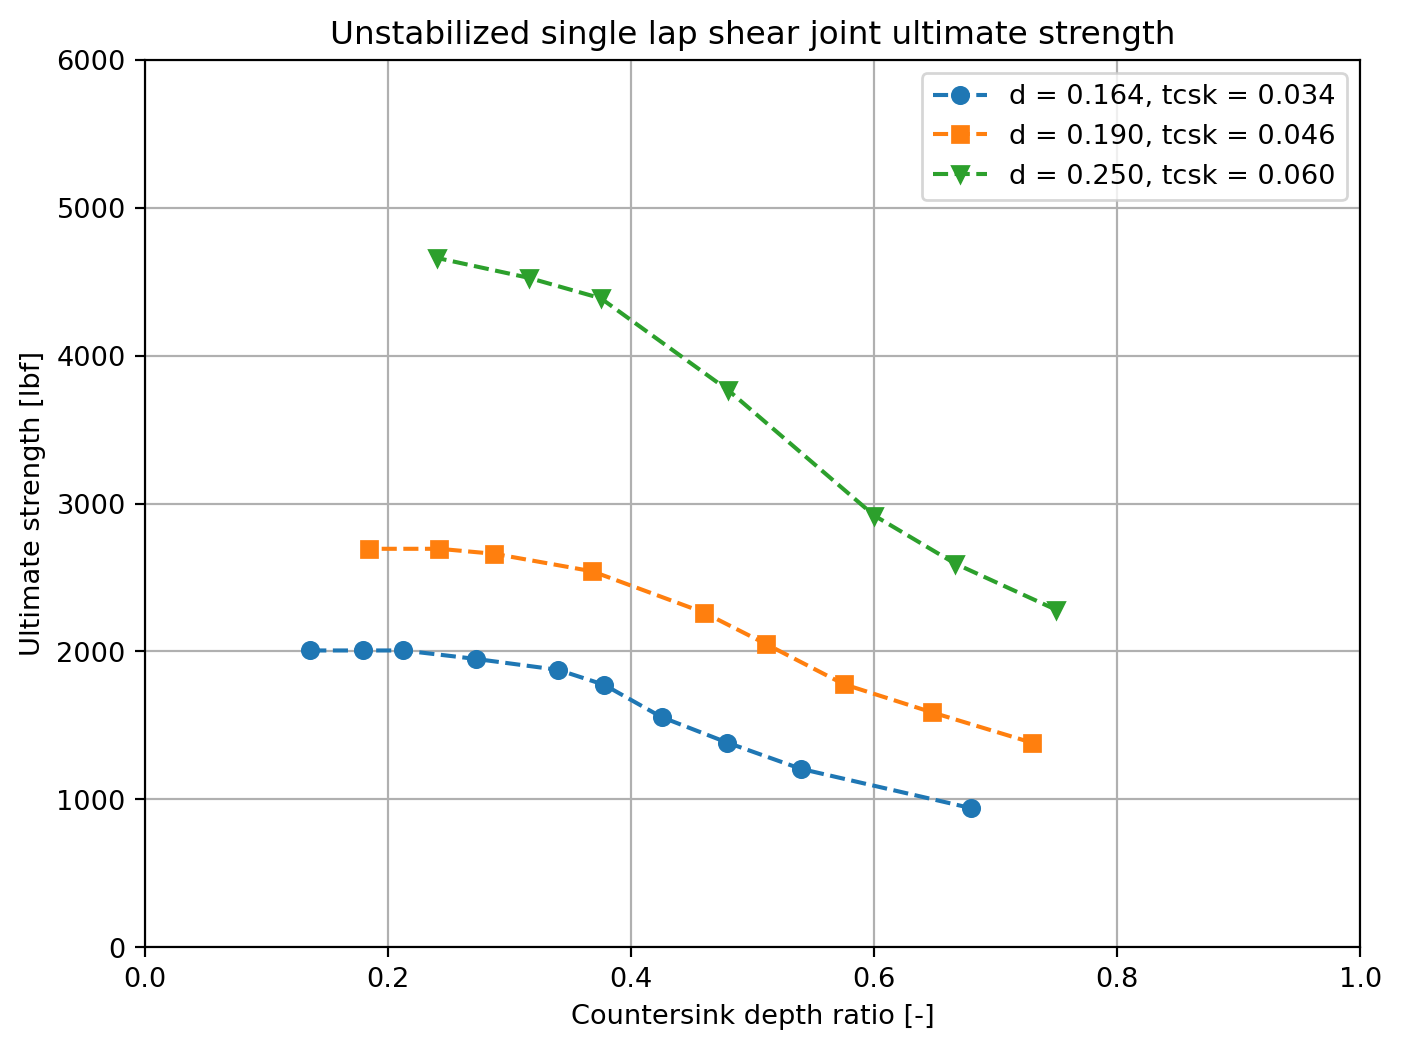

In [53]:
plt.figure(num=2,dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint ultimate strength')
plt.xlabel('Countersink depth ratio [-]')
plt.ylabel('Ultimate strength [lbf]')
plt.xlim((0,1))
plt.ylim((0,6000))
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
for i, m in enumerate(markers):
    plt.plot(t_csk_arr[i]/t_arr,Pult_csk_arr[:,i],marker=m, linestyle="--", color='C{:d}'.format(i), label='d = {:.3f}, tcsk = {:.3f}'.format(d_arr[i],t_csk_arr[i]))
plt.legend(loc='best')
plt.grid(visible=True, which='both', axis='both')

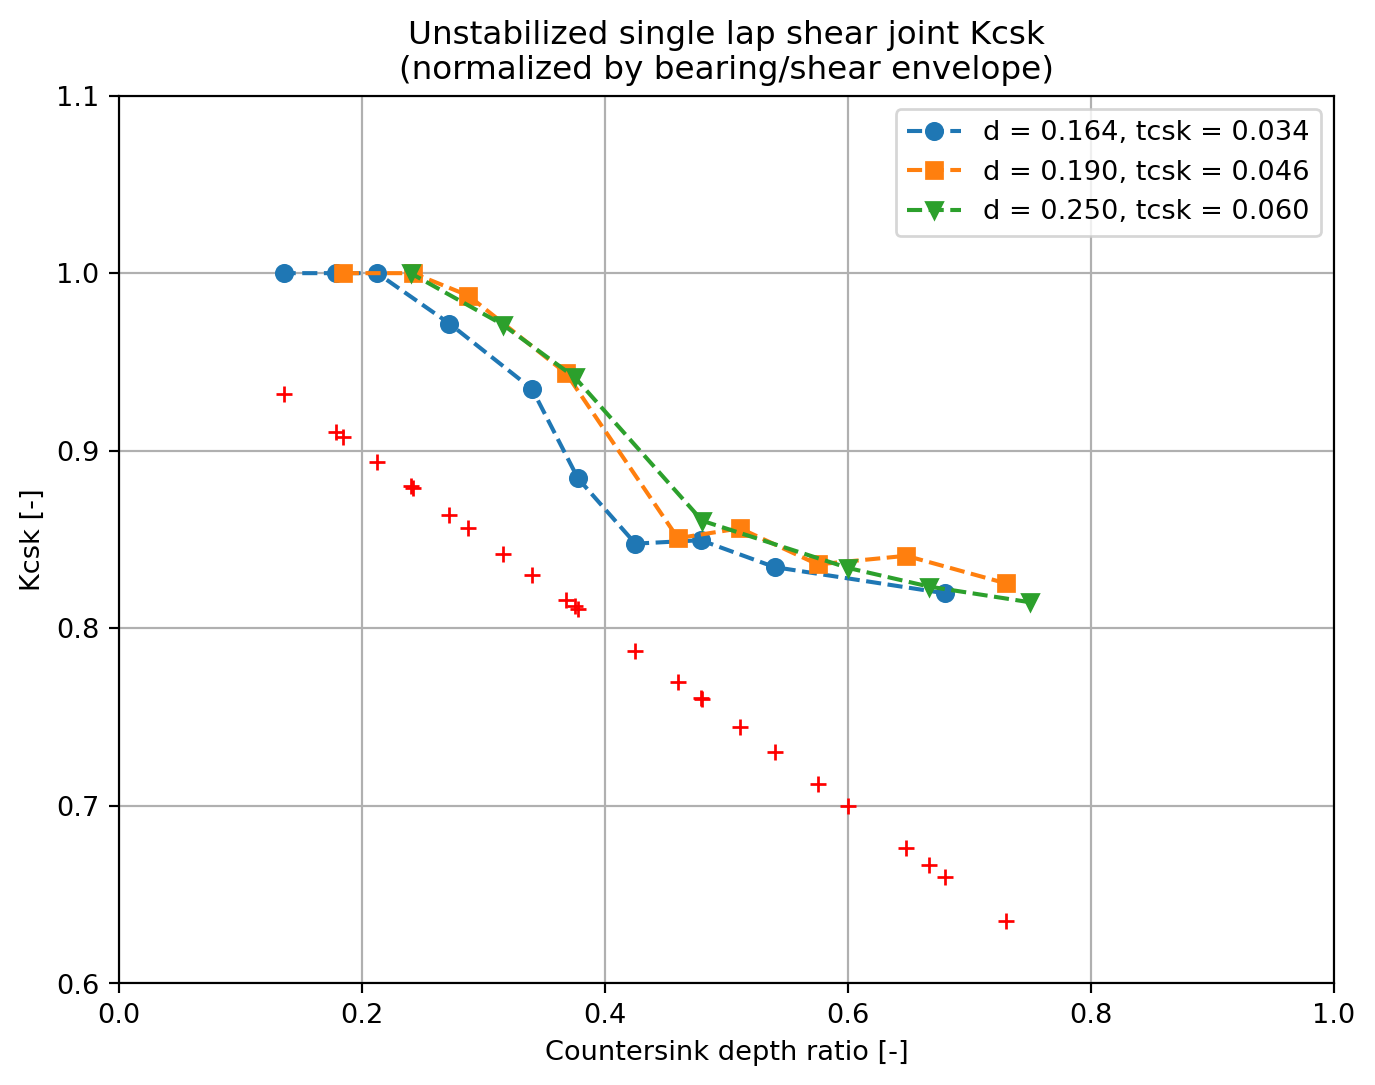

In [81]:
plt.figure(dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint Kcsk' +
        '\n(normalized by bearing/shear envelope)')
plt.xlabel('Countersink depth ratio [-]')
plt.ylabel('Kcsk [-]')
plt.xlim((0,1))
plt.ylim((0.6,1.1))
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
for i, m in enumerate(markers):
    plt.plot(t_csk_arr[i]/t_arr,Kcsk_bs[:,i],marker=m, linestyle="--", color='C{:d}'.format(i), label='d = {:.3f}, tcsk = {:.3f}'.format(d_arr[i],t_csk_arr[i]))
    plt.plot(t_csk_arr[i]/t_arr, Kalt[:,i], '+r')
plt.legend(loc='best')
plt.grid(visible=True, which='both', axis='both')

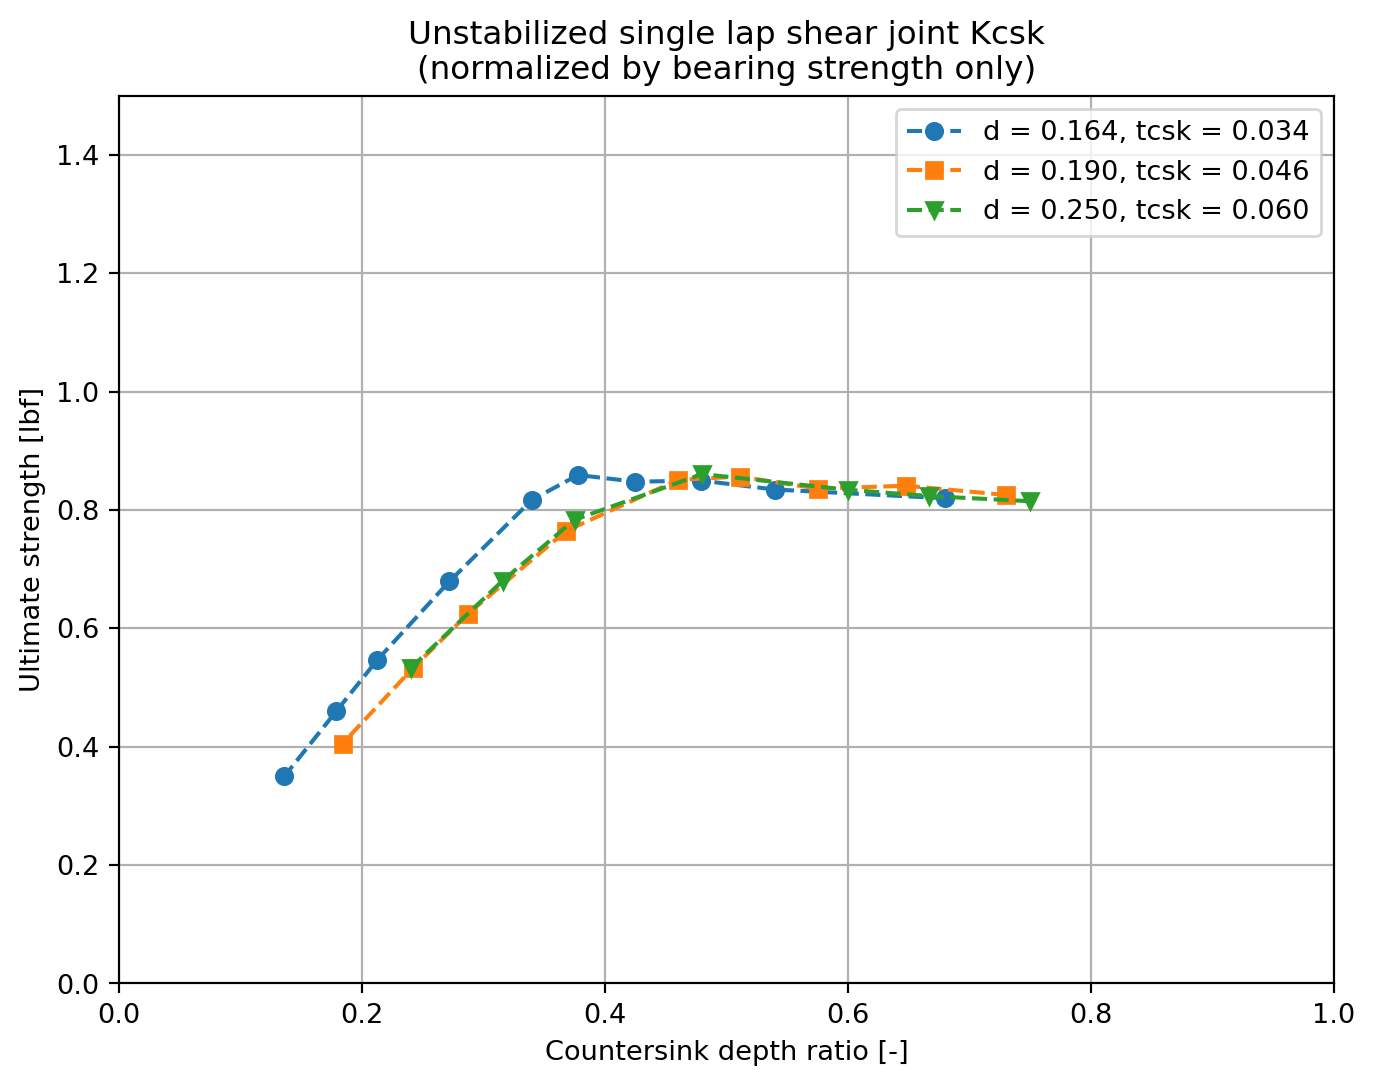

In [72]:
plt.figure(dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint Kcsk' +
        '\n(normalized by bearing strength only)')
plt.xlabel('Countersink depth ratio [-]')
plt.ylabel('Ultimate strength [lbf]')
plt.xlim((0,1))
plt.ylim((0,1.5))
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
for i, m in enumerate(markers):
    plt.plot(t_csk_arr[i]/t_arr,Kcsk_b[:,i],marker=m, linestyle="--", color='C{:d}'.format(i), label='d = {:.3f}, tcsk = {:.3f}'.format(d_arr[i],t_csk_arr[i]))
plt.legend(loc='best')
plt.grid(visible=True, which='both', axis='both')

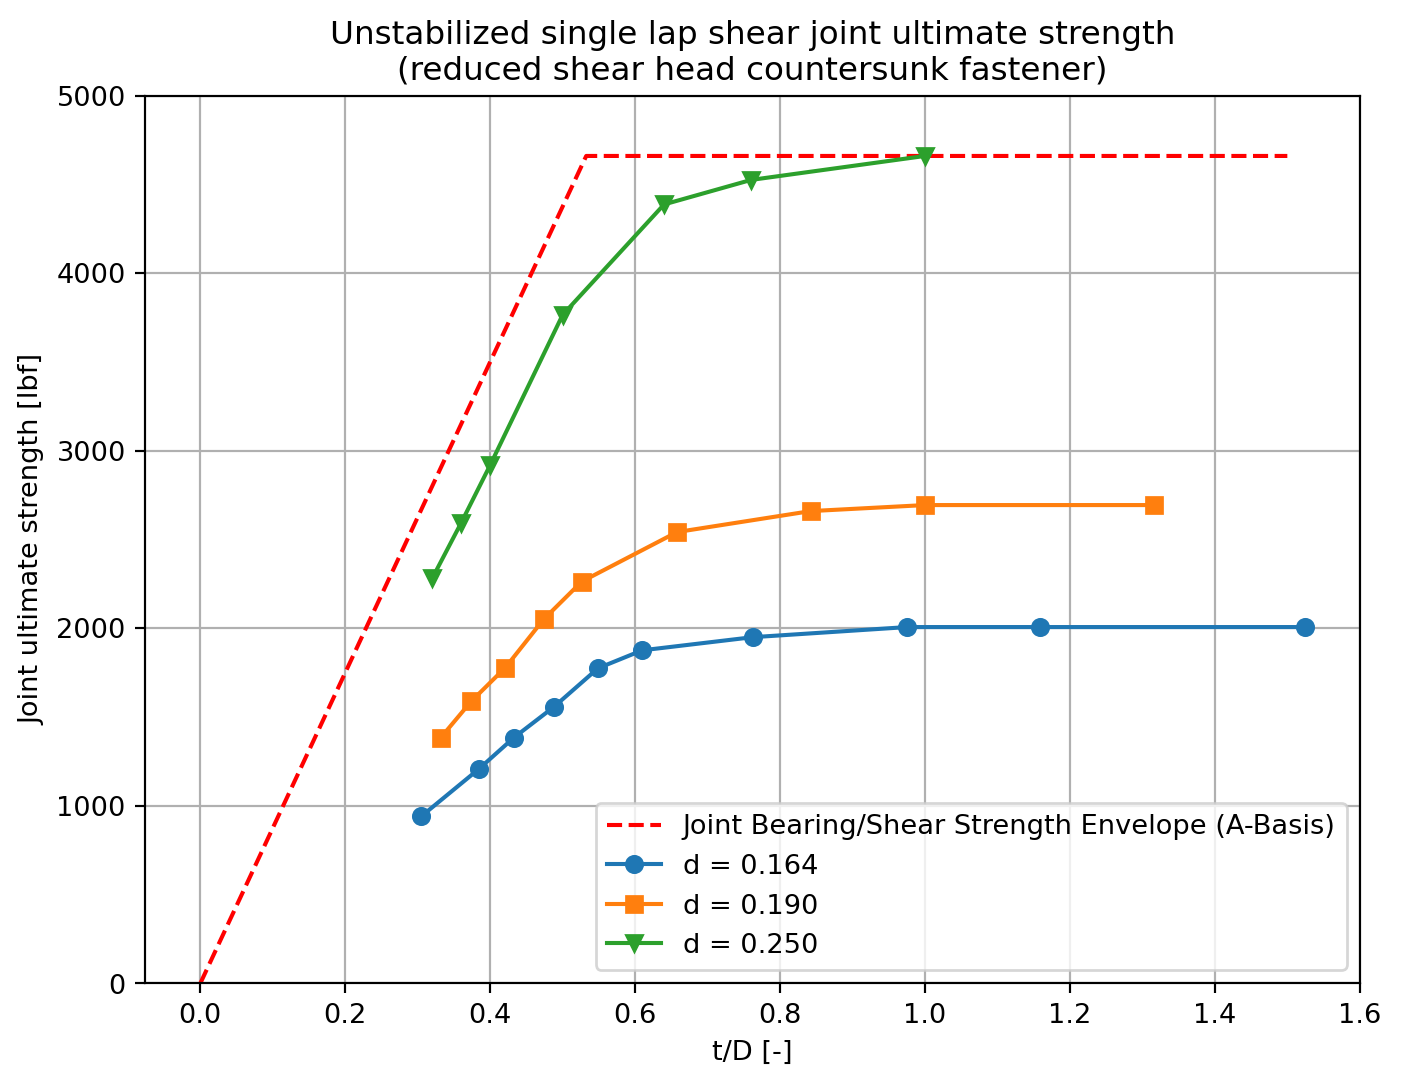

In [23]:
# x axis is normalized by fastener diameter
plt.figure(num=3,dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint ultimate strength\n(reduced shear head countersunk fastener)')
plt.xlabel('t/D [-]')
plt.ylabel('Joint ultimate strength [lbf]')
#plt.xlim((0.050, 0.3))
plt.ylim((0,5000))
plt.plot(tbru_A/D,Pbru_2A,'--r', label='Joint Bearing/Shear Strength Envelope (A-Basis)')
plt.plot()
#plt.plot(tbru_B,Pbru_2B,'--b', label='Joint Bearing/Shear Strength Envelope (B-Basis)')
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
plt.plot(t_arr/d_arr[0],Pult_csk_arr[:,0],marker='o', label='d = {:.3f}'.format(d_arr[0]))
plt.plot(t_arr/d_arr[1],Pult_csk_arr[:,1],marker='s', label='d = {:.3f}'.format(d_arr[1]))
plt.plot(t_arr/d_arr[2],Pult_csk_arr[:,2],marker='v', label='d = {:.3f}'.format(d_arr[2]))
#plt.plot(t,Pult_csk/0.85,'v', label='Countersunk head (TYP estimate)')
#plt.plot(tfit,x3fit(tfit),'--k')
plt.legend(loc=4)
plt.grid(visible=True, which='both', axis='both')